In [1]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 
import time

import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pickle

from scipy.stats import chi2
from pycaleva import CalibrationEvaluator
from utils import augmentation as aug

/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [3]:
# def split_train_test_val(data, target, test_size, val_size):
#     nb_samples = len(target)
#     nb_test = int(test_size * nb_samples)
#     nb_val = int(val_size * nb_samples)

#     shuffle = list(range(nb_samples))
#     random.shuffle(shuffle)

#     x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
#     nb_0_test = 0
#     nb_1_test = 0
#     nb_0_val = 0
#     nb_1_val = 0

#     for idx in shuffle:
#         if nb_0_test < (nb_test//2) and target[idx]==0:
#             y_test.append(0)
#             x_test.append(data[idx])
#             nb_0_test += 1
#         elif nb_1_test < (nb_test//2) and target[idx]==1:
#             y_test.append(1)
#             x_test.append(data[idx])
#             nb_1_test += 1
#         elif nb_0_val < (nb_val//2) and target[idx]==0:
#             y_val.append(0)
#             x_val.append(data[idx])
#             nb_0_val += 1
#         elif nb_1_val < (nb_val//2) and target[idx]==1:
#             y_val.append(1)
#             x_val.append(data[idx])
#             nb_1_val += 1
#         else:
#             y_train.append(target[idx])
#             x_train.append(data[idx])
    
#     return x_train, x_test, x_val, y_train, y_test, y_val


def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> SpO2/FiO2
        # 9 --> FiO2
        # 10 --> ECMO flow
        
        # idx_variables_kept = [0,1,3,4,6,7]
        if dataGroup == "dataECMO":
            # idx_variables_kept = [0,1,2,3,4,5,6,7,8,9]
            idx_variables_kept = [0,1,2,3,4,5,6,7,9]
        else:
            idx_variables_kept = [0,1,2,3,4,5,6,7,9]

        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
        
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # # idx_variables_kept = [0,1,3,4,6,7]
        # idx_variables_kept = list(range(0,10))
        # df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        # df_dynamic = df_dynamic.iloc[:,idx_variables_kept]


        data.append(data_patient)
    
    return np.array(data)


def prepareDeathList(dataGroup, window_time):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        patients_df = pd.read_csv(dataPath + "ventiles.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                target.append(label_death)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [4]:
target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = prepareData("dataECMO", id_list_ECMO, window_time=5)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 162.80it/s]

ECMO dataset size: 153 , num_deceased: 55


In [5]:
target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
data_Rangueil = prepareData("dataRangueil", id_list_Rangueil, window_time=5)

print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1697/1697 [00:10<00:00, 167.48it/s]

Rea dataset size: 1697 , num_deceased: 445


In [6]:
target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
data_Mimic = prepareData("dataMimic", id_list_Mimic, window_time=5)

print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4184/4184 [00:25<00:00, 166.34it/s]

Mimic dataset size: 4184 , num_deceased: 1078


In [7]:
target_MR = target_Mimic + target_Rangueil
id_list = id_list_Mimic + id_list_Rangueil

data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

dataset size mimic+rea: 5881 , num_deceased: 1523


In [8]:
class CNN_1D_0(nn.Module):
    def __init__(self, num_features, num_static_features):
        super(CNN_1D_0, self).__init__()
        
        self.num_features = num_features
        self.num_static_features = num_static_features

        self.conv1 = nn.Conv1d(in_channels=num_features-num_static_features, out_channels=8, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(480 , 4)
        self.fc2 = nn.Linear(4+num_static_features, 1)  

        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        cnn_input = x[:, :-self.num_static_features, :]
        static_input = x[:, -self.num_static_features:, 0]

        out = self.pool(nn.functional.relu(self.conv1(cnn_input)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = torch.cat((out, static_input), dim=1)
        # out = self.dropout1(out)
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN_1D_1(nn.Module):
    def __init__(self, num_features):
        super(CNN_1D_1, self).__init__()
        
        self.num_features = num_features

        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(1920 , 32)
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):

        out = self.pool(nn.functional.relu(self.conv1(x)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 3), padding=1)
        
        self.fc1 = nn.Linear(2976, 4) 
        self.fc2 = nn.Linear(4, 1)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.75)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        # x = nn.functional.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_static_features):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_static_features = num_static_features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size + num_static_features, 20)
        # self.fc2 = nn.Linear(20, output_size)
        self.fc2 = nn.Linear(hidden_size + num_static_features, 1)
    
    def forward(self, x):
        lstm_input = x[:, :, :-self.num_static_features]
        static_input = x[:, 0, -self.num_static_features:]

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(lstm_input, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step

        out = torch.cat((out, static_input), dim=1)
        # out = torch.relu(self.fc1(out))

        # out = nn.functional.sigmoid(self.fc2(out))
        out = self.fc2(out)
        return out

class LSTMModel2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static):
        
        super(LSTMModel2, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_features_dynamic = num_features_dynamic
        self.num_features_static = num_features_static
        
        # Create a list of LSTM layers, one for each feature
        self.lstms = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) for _ in range(num_features_dynamic)])
        
        # Linear layer for binary classification
        self.fc = nn.Linear(hidden_size*num_features_dynamic + num_features_static, output_size)
        
    def forward(self, x):
        
        lstm_outputs = []

        for i in range(self.num_features_dynamic):
            feature_input = x[:, :, i].unsqueeze(2)  # Shape: (batch_size, seq_length, 1)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            lstm_out, _ = self.lstms[i](feature_input, (h0, c0))
            lstm_out = lstm_out[:, -1, :]  # Get the last time step output: Shape: (batch_size, hidden_size)
            lstm_outputs.append(lstm_out)
        
        # Concatenate the outputs from each LSTM
        out = torch.cat(lstm_outputs, dim=1)  # Shape: (batch_size, hidden_size * num_features)
        
        static_input = x[:, 0, -self.num_features_static:]
        out = torch.cat((out, static_input), dim=1)
        
        out = self.fc(out)
        # out = nn.functional.sigmoid(self.fc(out))  # Shape: (batch_size, output_size)
        
        return out

In [80]:
def augment(X_train, Y_train):
    indices = np.where(np.array(Y_train) == 1)
    X_deceased = X_train[indices]
    
    x_aug_3 = aug.magnitude_warp(X_deceased, sigma=0.2, knot=4)
    # x_aug_3 = aug.window_warp(X_deceased)
    # x_aug_3 = aug.spawner(X_deceased, np.ones(np.shape(X_deceased)[0]))
    # x_aug_3 = aug.wdba(X_deceased, np.ones(np.shape(X_deceased)[0]))

    x_train = np.concatenate((X_train, x_aug_3))

    y_train = np.concatenate((Y_train, np.ones(np.shape(x_train)[0]-np.shape(X_train)[0])))
    
    return x_train, y_train

In [81]:

def train_model(data, target, test_fold, validation_activated, test_activated, num_epochs, model_name, verbose, save_path, save_model, plot_train_curves, calibration_activated, augmentation_activated, load_model_path=None):
    
    # x_train, x_test, x_val, y_train, y_test, y_val = split_train_test_val(data, target, test_size=test_size, val_size=val_size)
    # if test_size > 0:
    #     x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
    #     while np.sum(y_test) < 2:
    #         x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)

    #     if val_size > 0:
    #         x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
    #         while np.sum(y_val) == 0:
    #             x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
    #     else:
    #         x_val = np.array([])
    #         y_val = np.array([])
    # else:
    #     x_test = np.array([])
    #     y_test = np.array([])
    #     x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)
    #     while np.sum(y_val) < 2:
    #         x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)
    
    num_samples = len(target)
    K = 10
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,K-1)
        while val_fold == test_fold:
            val_fold = random.randint(0,K-1)
    else:
        val_fold = None
    
    X_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    Y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            X_train = np.concatenate((X_train, current_data_fold))
            Y_train = Y_train + current_target_fold

    if augmentation_activated:
        x_train, y_train = augment(X_train, Y_train)
    else:
        x_train, y_train = X_train, Y_train
    
    print(f"proportion deceased: {np.sum(y_train)/np.size(y_train)}")

    num_timesteps = np.size(x_train,1)
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 64

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)


    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    if model_name == "CNN_1D_0":
        model = CNN_1D_0(num_features=num_features, num_static_features=num_features_static)

        # if verbose:
        #     print(torchinfo.summary(model, input_size=(batch_size, num_features, num_timesteps)))
    
    if model_name == "CNN_1D_1":
        model = CNN_1D_1(num_features=num_features)

    elif model_name == "CNN2":
            model = CNN2()

            if verbose:
                print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    elif model_name == "LSTM":
        input_size = num_features-num_features_static
        hidden_size = 32
        num_layers = 2
        output_size = 1

        model = LSTMModel(input_size, hidden_size, num_layers, output_size, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if model_name == "LSTM2":
        input_size = 1
        hidden_size = 8
        num_layers = 1
        output_size = 1

        model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if load_model_path != None:
        state_dict = torch.load(load_model_path)
        model.load_state_dict(state_dict)

        if model_name == "CNN_1D_1":
            for param in model.conv1.parameters():
                param.requires_grad = False
            for param in model.conv2.parameters():
                param.requires_grad = False

    # criterion = nn.BCELoss()  # Binary cross-entropy loss

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_auroc = 0
    best_model_state = None
    val_auroc_list = []
    train_auroc_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.cpu().numpy())
            
            true_labels.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.3f}, Train AUROC: {train_auroc:.3f}")

        # Validation
        if validation_activated:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.cpu().numpy())

                    true_labels.extend(labels.cpu().numpy())
                    
        
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.3f}, Validation AUROC: {val_auroc:.3f}")
            if val_auroc > best_val_auroc and val_auroc < train_auroc:
                best_val_auroc = val_auroc
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), save_path)

                if calibration_activated:
                    predictions = np.array(predictions).squeeze()
                    val_deciles = np.percentile(predictions, np.arange(0, 101, 10))
                    val_decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
                    
                    val_HL_num_groups = np.zeros(10)
                    val_HL_pred_groups = np.zeros(10)
                    val_HL_true_groups = np.zeros(10)
                    
                    for k in range(len(predictions)):
                        group = val_decile_labels[k]
                        val_HL_num_groups[group] +=1
                        val_HL_pred_groups[group] += predictions[k]
                        if true_labels[k] > 0.5:
                            val_HL_true_groups[group] += 1
            

    if validation_activated:
        if best_val_auroc > 0:
            state_dict = torch.load(save_path)
            model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(5, 3))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

    if test_activated:
        model.eval()
    
        auroc, precision, recall, tnr, f1, accuracy = 0,0,0,0,0,0 
    
        true_labels = []
        predictions = []
        predictions_binary = []
    
        treshold = 0.5
        
        with torch.no_grad():
            for inputs, labels in test_loader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                
                true_labels.extend(labels.cpu().numpy())
    
                outputs = nn.functional.sigmoid(model(inputs)).cpu().numpy()
                predictions.extend(outputs)
                predictions_binary.extend((outputs > treshold).astype(int))
    
    
        predictions = np.array(predictions).squeeze()
###############
        deciles = np.percentile(predictions, np.arange(0, 101, 10))
        decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)

        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        for k in range(len(predictions)):
            group = decile_labels[k]
            HL_num_groups[group] +=1
            HL_pred_groups[group] += predictions[k]
            if true_labels[k] > 0.5:
                HL_true_groups[group] += 1

        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
        HL_p_value = 1 - chi2.cdf(HL_score, df=8)
        
        plt.figure(figsize=(8, 5))

        plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('Decile')
        plt.ylabel('hospital mortality')
        plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

        plt.legend()

        plt.show()
##################
        
        if validation_activated and calibration_activated and best_val_auroc > 0:
            decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
            for k in range(len(predictions)):
                if predictions[k] < val_deciles[0]:
                    group = 0
                elif predictions[k] > val_deciles[-1]:
                    group = 9
                else:
                    group = int(decile_labels[k])
                predictions[k] = val_HL_true_groups[group]/val_HL_num_groups[group] + random.random()*0.0000001

        deciles = np.percentile(predictions, np.arange(0, 101, 10))
        decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)

        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        for k in range(len(predictions)):
            group = decile_labels[k]
            HL_num_groups[group] +=1
            HL_pred_groups[group] += predictions[k]
            if true_labels[k] > 0.5:
                HL_true_groups[group] += 1
                
        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
        HL_p_value = 1 - chi2.cdf(HL_score, df=8)
        
        plt.figure(figsize=(8, 5))

        plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('Decile')
        plt.ylabel('hospital mortality')
        plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

        plt.legend()

        plt.show()
        
        auroc = roc_auc_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions_binary, zero_division=0)
        recall = recall_score(true_labels, predictions_binary, zero_division=0)
        tnr = tnr_score(true_labels, predictions_binary)
        f1 = f1_score(true_labels, predictions_binary, zero_division=0)
        accuracy = accuracy_score(true_labels, predictions_binary)
    
    # if verbose:
    # print("Test AUROC score:", auroc)

        return auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, best_model_state, predictions, true_labels
    # else:
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

proportion deceased: 0.2558979808714134
Epoch 1/50, Train loss: 81.827, Train AUROC: 0.677
Validation Loss: 11.268, Validation AUROC: 0.701
Epoch 2/50, Train loss: 76.779, Train AUROC: 0.736
Validation Loss: 11.160, Validation AUROC: 0.713
Epoch 3/50, Train loss: 74.768, Train AUROC: 0.755
Validation Loss: 11.212, Validation AUROC: 0.714
Epoch 4/50, Train loss: 73.022, Train AUROC: 0.771
Validation Loss: 11.297, Validation AUROC: 0.714
Epoch 5/50, Train loss: 71.340, Train AUROC: 0.785
Validation Loss: 11.395, Validation AUROC: 0.713
Epoch 6/50, Train loss: 69.626, Train AUROC: 0.798
Validation Loss: 11.531, Validation AUROC: 0.710
Epoch 7/50, Train loss: 67.807, Train AUROC: 0.811
Validation Loss: 11.712, Validation AUROC: 0.706
Epoch 8/50, Train loss: 65.831, Train AUROC: 0.824
Validation Loss: 11.929, Validation AUROC: 0.701
Epoch 9/50, Train loss: 63.712, Train AUROC: 0.837
Validation Loss: 12.181, Validation AUROC: 0.696
Epoch 10/50, Train loss: 61.427, Train AUROC: 0.851
Validati

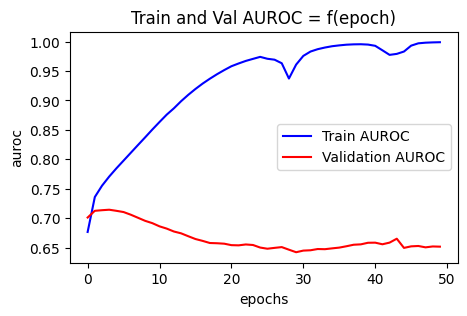

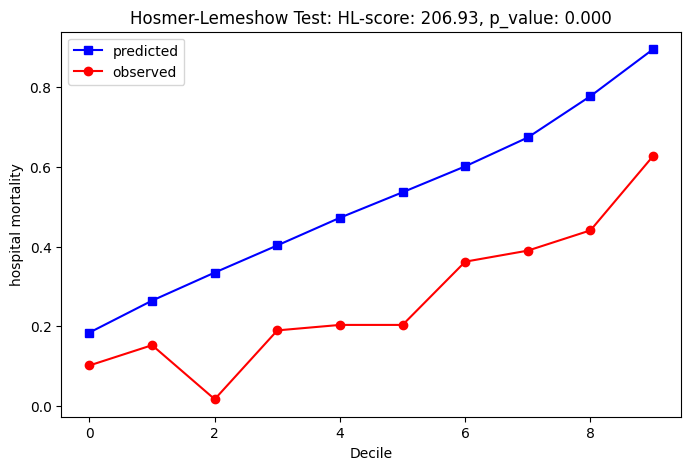

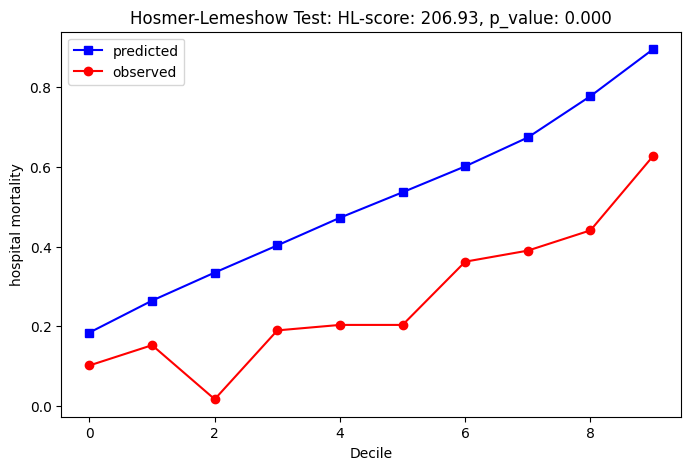


 10%|███████████████▉                                                                                                                                               | 1/10 [00:13<02:05, 13.92s/it]

test AUROC: 0.736
test Precision: 0.404
test Recall: 0.759
test Specificity: 0.495
test Accuracy: 0.634
test F1 Score: 0.527
test HL Score: 206.932
proportion deceased: 0.26184909670563233
Epoch 1/50, Train loss: 82.033, Train AUROC: 0.670
Validation Loss: 10.726, Validation AUROC: 0.711
Epoch 2/50, Train loss: 77.718, Train AUROC: 0.722
Validation Loss: 10.622, Validation AUROC: 0.719
Epoch 3/50, Train loss: 75.782, Train AUROC: 0.742
Validation Loss: 10.578, Validation AUROC: 0.724
Epoch 4/50, Train loss: 74.134, Train AUROC: 0.757
Validation Loss: 10.534, Validation AUROC: 0.728
Epoch 5/50, Train loss: 72.637, Train AUROC: 0.771
Validation Loss: 10.572, Validation AUROC: 0.726
Epoch 6/50, Train loss: 71.159, Train AUROC: 0.783
Validation Loss: 10.637, Validation AUROC: 0.725
Epoch 7/50, Train loss: 69.648, Train AUROC: 0.794
Validation Loss: 10.723, Validation AUROC: 0.724
Epoch 8/50, Train loss: 68.036, Train AUROC: 0.806
Validation Loss: 10.850, Validation AUROC: 0.721
Epoch 9/50,

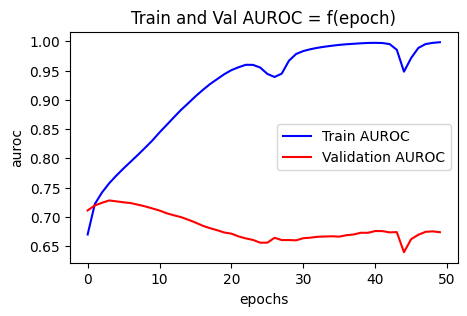

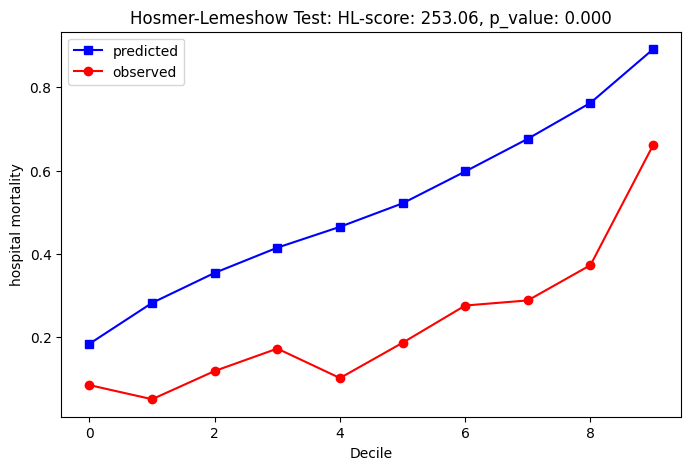

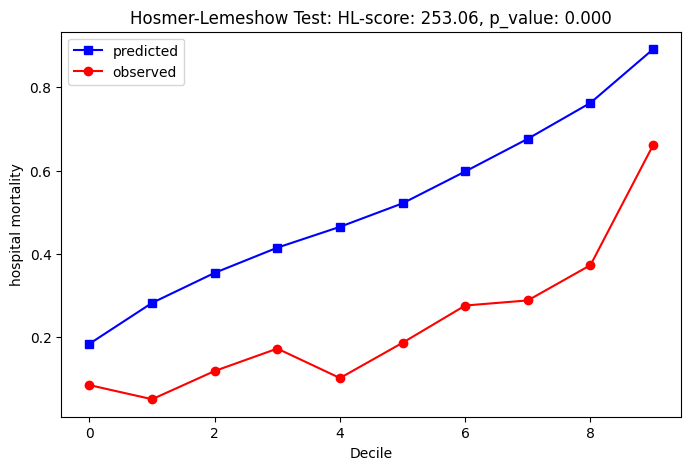


 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:27<01:49, 13.74s/it]

test AUROC: 0.747
test Precision: 0.361
test Recall: 0.765
test Specificity: 0.510
test Accuracy: 0.633
test F1 Score: 0.491
test HL Score: 253.058
proportion deceased: 0.26184909670563233
Epoch 1/50, Train loss: 81.261, Train AUROC: 0.680
Validation Loss: 9.754, Validation AUROC: 0.749
Epoch 2/50, Train loss: 77.204, Train AUROC: 0.728
Validation Loss: 9.701, Validation AUROC: 0.756
Epoch 3/50, Train loss: 75.555, Train AUROC: 0.745
Validation Loss: 9.757, Validation AUROC: 0.753
Epoch 4/50, Train loss: 74.233, Train AUROC: 0.757
Validation Loss: 9.846, Validation AUROC: 0.748
Epoch 5/50, Train loss: 72.897, Train AUROC: 0.770
Validation Loss: 9.953, Validation AUROC: 0.743
Epoch 6/50, Train loss: 71.492, Train AUROC: 0.782
Validation Loss: 10.046, Validation AUROC: 0.737
Epoch 7/50, Train loss: 70.044, Train AUROC: 0.794
Validation Loss: 10.125, Validation AUROC: 0.732
Epoch 8/50, Train loss: 68.374, Train AUROC: 0.807
Validation Loss: 10.195, Validation AUROC: 0.727
Epoch 9/50, Trai

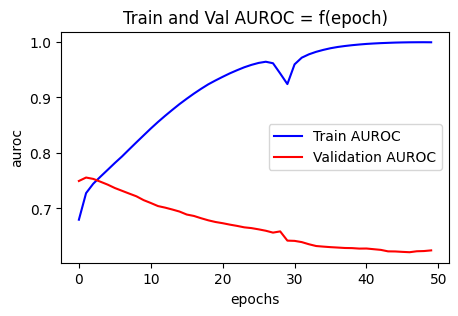

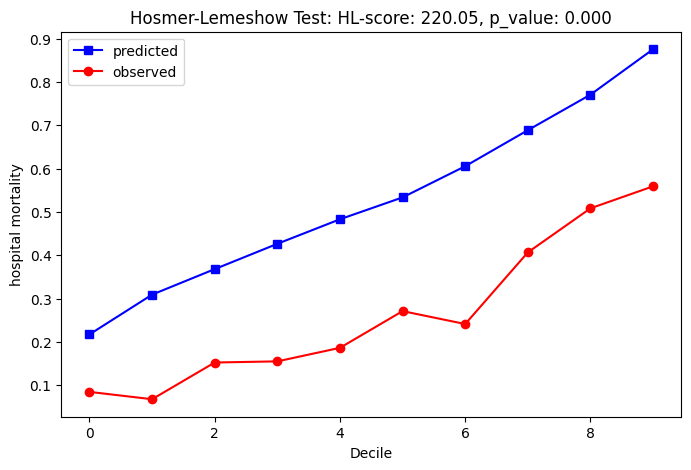

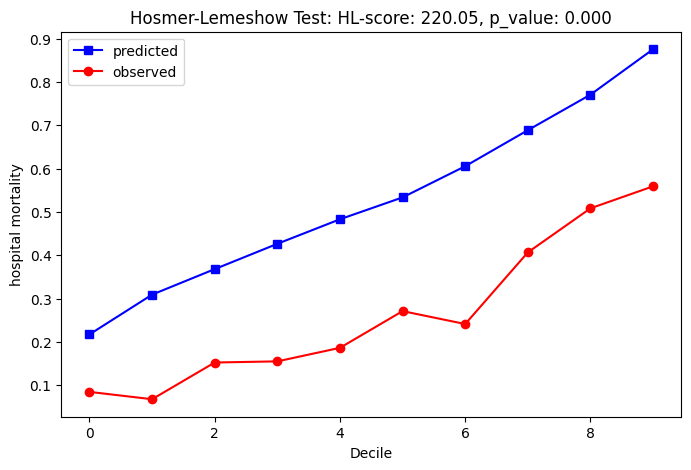


 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:41<01:35, 13.68s/it]

test AUROC: 0.733
test Precision: 0.392
test Recall: 0.774
test Specificity: 0.480
test Accuracy: 0.624
test F1 Score: 0.521
test HL Score: 220.046
proportion deceased: 0.2561105207226355
Epoch 1/50, Train loss: 82.252, Train AUROC: 0.670
Validation Loss: 11.580, Validation AUROC: 0.691
Epoch 2/50, Train loss: 76.755, Train AUROC: 0.737
Validation Loss: 11.533, Validation AUROC: 0.696
Epoch 3/50, Train loss: 74.870, Train AUROC: 0.755
Validation Loss: 11.615, Validation AUROC: 0.698
Epoch 4/50, Train loss: 73.382, Train AUROC: 0.768
Validation Loss: 11.662, Validation AUROC: 0.697
Epoch 5/50, Train loss: 71.847, Train AUROC: 0.781
Validation Loss: 11.746, Validation AUROC: 0.698
Epoch 6/50, Train loss: 70.141, Train AUROC: 0.794
Validation Loss: 11.859, Validation AUROC: 0.698
Epoch 7/50, Train loss: 68.248, Train AUROC: 0.808
Validation Loss: 12.020, Validation AUROC: 0.696
Epoch 8/50, Train loss: 66.285, Train AUROC: 0.821
Validation Loss: 12.306, Validation AUROC: 0.694
Epoch 9/50, 

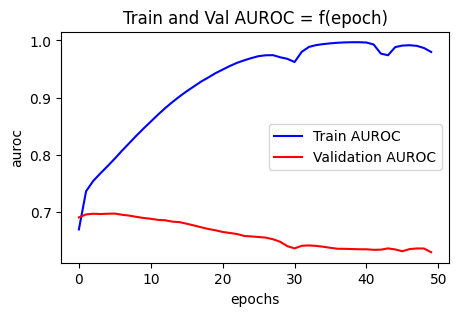

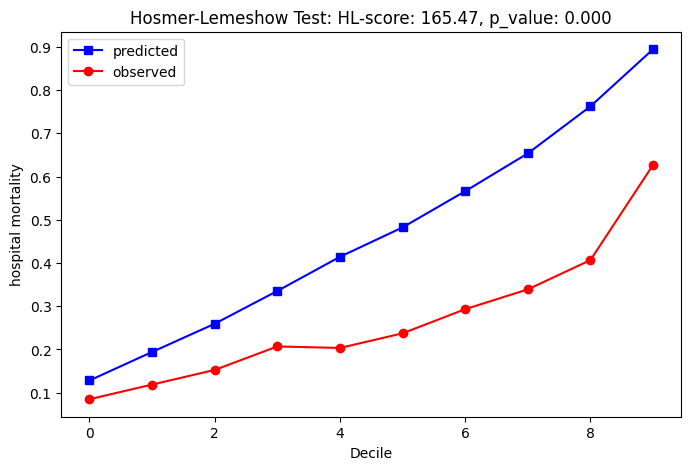

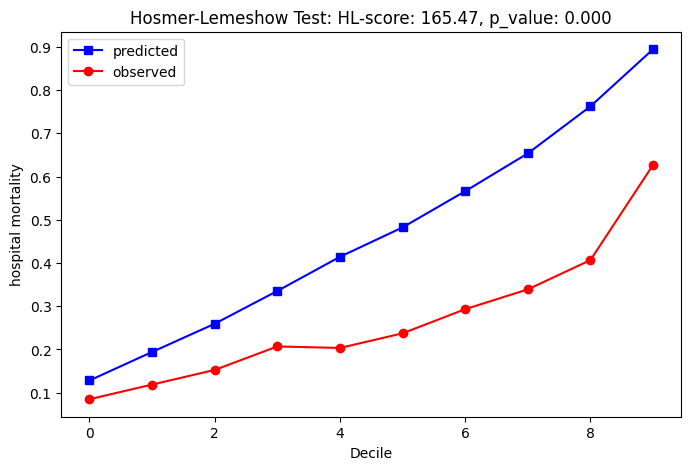


 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:54<01:21, 13.66s/it]

test AUROC: 0.709
test Precision: 0.406
test Recall: 0.643
test Specificity: 0.577
test Accuracy: 0.653
test F1 Score: 0.498
test HL Score: 165.472
proportion deceased: 0.2558979808714134
Epoch 1/50, Train loss: 81.984, Train AUROC: 0.673
Validation Loss: 11.164, Validation AUROC: 0.701
Epoch 2/50, Train loss: 77.199, Train AUROC: 0.732
Validation Loss: 11.102, Validation AUROC: 0.705
Epoch 3/50, Train loss: 75.501, Train AUROC: 0.749
Validation Loss: 11.098, Validation AUROC: 0.707
Epoch 4/50, Train loss: 74.071, Train AUROC: 0.762
Validation Loss: 11.125, Validation AUROC: 0.706
Epoch 5/50, Train loss: 72.708, Train AUROC: 0.774
Validation Loss: 11.129, Validation AUROC: 0.706
Epoch 6/50, Train loss: 71.097, Train AUROC: 0.786
Validation Loss: 11.194, Validation AUROC: 0.704
Epoch 7/50, Train loss: 69.515, Train AUROC: 0.798
Validation Loss: 11.333, Validation AUROC: 0.698
Epoch 8/50, Train loss: 67.918, Train AUROC: 0.810
Validation Loss: 11.539, Validation AUROC: 0.693
Epoch 9/50, 

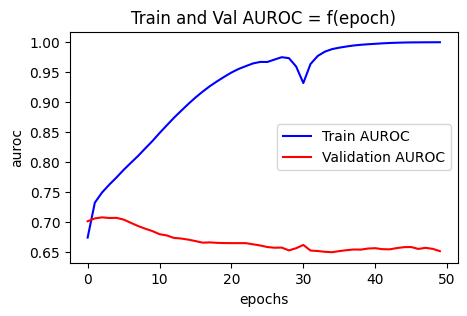

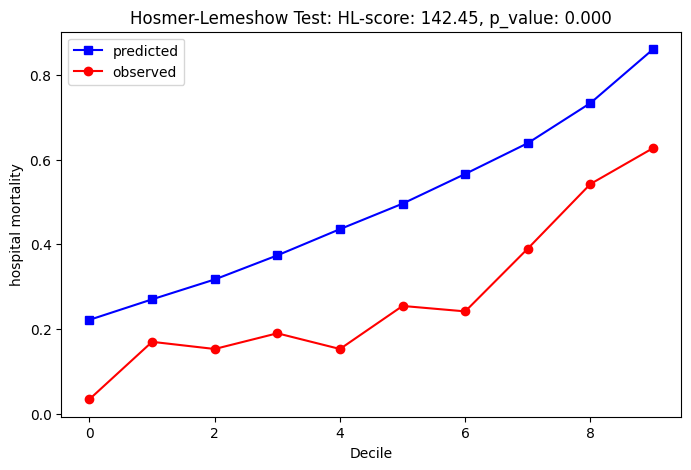

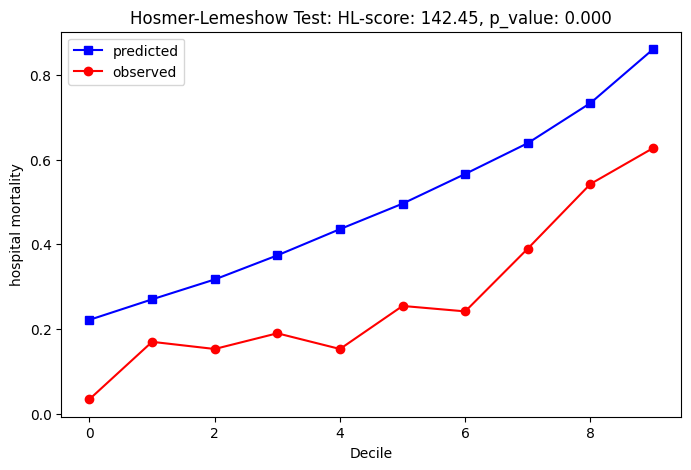


 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [01:08<01:08, 13.64s/it]

test AUROC: 0.744
test Precision: 0.444
test Recall: 0.716
test Specificity: 0.556
test Accuracy: 0.675
test F1 Score: 0.548
test HL Score: 142.449
proportion deceased: 0.259086078639745
Epoch 1/50, Train loss: 81.056, Train AUROC: 0.681
Validation Loss: 10.912, Validation AUROC: 0.705
Epoch 2/50, Train loss: 77.033, Train AUROC: 0.731
Validation Loss: 10.855, Validation AUROC: 0.713
Epoch 3/50, Train loss: 75.144, Train AUROC: 0.750
Validation Loss: 10.815, Validation AUROC: 0.714
Epoch 4/50, Train loss: 73.408, Train AUROC: 0.765
Validation Loss: 10.825, Validation AUROC: 0.713
Epoch 5/50, Train loss: 71.557, Train AUROC: 0.780
Validation Loss: 10.892, Validation AUROC: 0.708
Epoch 6/50, Train loss: 69.548, Train AUROC: 0.795
Validation Loss: 11.001, Validation AUROC: 0.704
Epoch 7/50, Train loss: 67.132, Train AUROC: 0.812
Validation Loss: 11.104, Validation AUROC: 0.699
Epoch 8/50, Train loss: 64.695, Train AUROC: 0.828
Validation Loss: 11.334, Validation AUROC: 0.698
Epoch 9/50, T

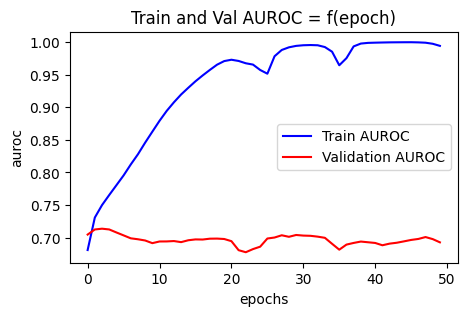

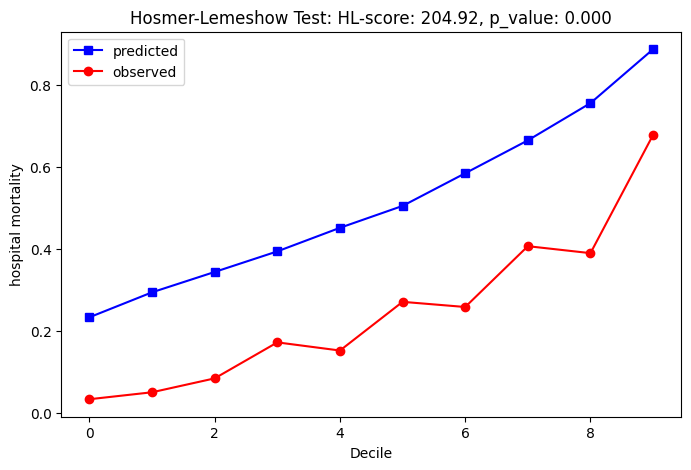

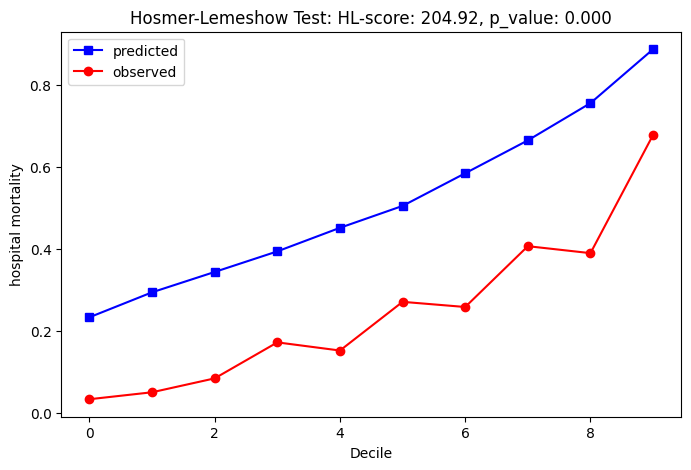


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [01:21<00:54, 13.62s/it]

test AUROC: 0.777
test Precision: 0.424
test Recall: 0.762
test Specificity: 0.551
test Accuracy: 0.682
test F1 Score: 0.545
test HL Score: 204.920
proportion deceased: 0.2597236981934113
Epoch 1/50, Train loss: 80.818, Train AUROC: 0.686
Validation Loss: 10.492, Validation AUROC: 0.734
Epoch 2/50, Train loss: 76.545, Train AUROC: 0.738
Validation Loss: 10.324, Validation AUROC: 0.742
Epoch 3/50, Train loss: 74.557, Train AUROC: 0.757
Validation Loss: 10.297, Validation AUROC: 0.742
Epoch 4/50, Train loss: 72.761, Train AUROC: 0.773
Validation Loss: 10.286, Validation AUROC: 0.741
Epoch 5/50, Train loss: 70.859, Train AUROC: 0.789
Validation Loss: 10.359, Validation AUROC: 0.739
Epoch 6/50, Train loss: 68.925, Train AUROC: 0.803
Validation Loss: 10.421, Validation AUROC: 0.736
Epoch 7/50, Train loss: 66.901, Train AUROC: 0.818
Validation Loss: 10.589, Validation AUROC: 0.732
Epoch 8/50, Train loss: 64.699, Train AUROC: 0.832
Validation Loss: 10.770, Validation AUROC: 0.728
Epoch 9/50, 

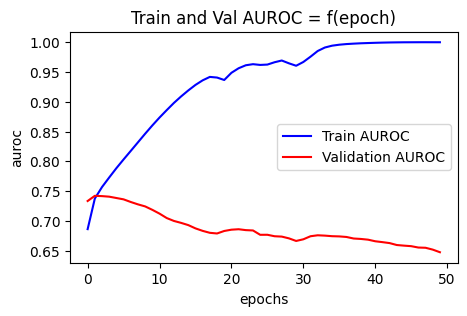

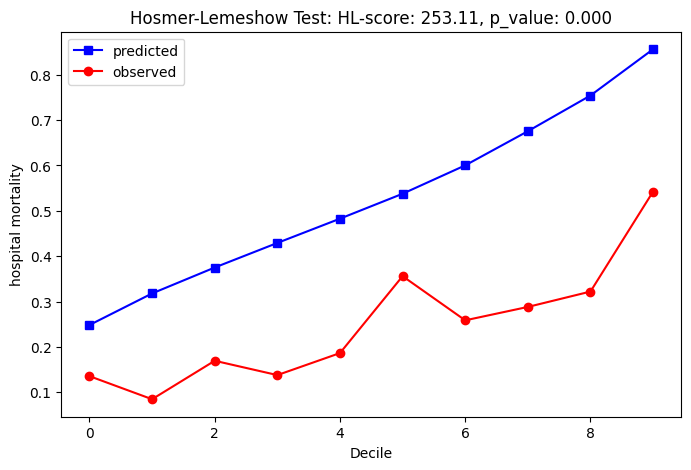

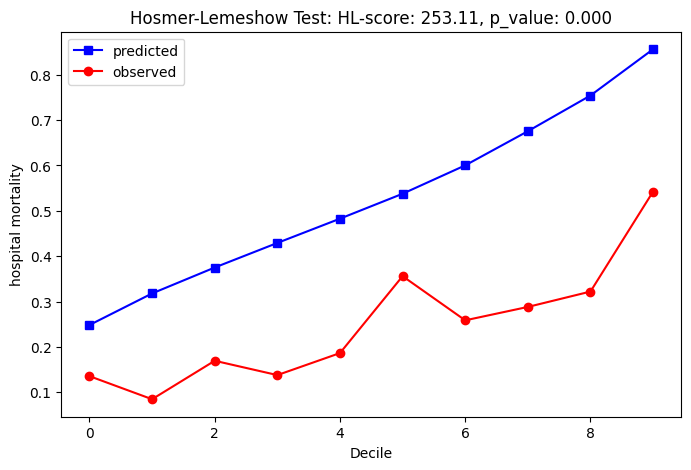


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [01:35<00:40, 13.62s/it]

test AUROC: 0.678
test Precision: 0.351
test Recall: 0.726
test Specificity: 0.486
test Accuracy: 0.599
test F1 Score: 0.473
test HL Score: 253.114
proportion deceased: 0.2605738575982997
Epoch 1/50, Train loss: 81.163, Train AUROC: 0.682
Validation Loss: 10.063, Validation AUROC: 0.732
Epoch 2/50, Train loss: 76.369, Train AUROC: 0.737
Validation Loss: 9.984, Validation AUROC: 0.739
Epoch 3/50, Train loss: 74.339, Train AUROC: 0.757
Validation Loss: 10.013, Validation AUROC: 0.738
Epoch 4/50, Train loss: 72.615, Train AUROC: 0.772
Validation Loss: 10.088, Validation AUROC: 0.733
Epoch 5/50, Train loss: 70.895, Train AUROC: 0.786
Validation Loss: 10.123, Validation AUROC: 0.731
Epoch 6/50, Train loss: 68.942, Train AUROC: 0.801
Validation Loss: 10.194, Validation AUROC: 0.729
Epoch 7/50, Train loss: 66.825, Train AUROC: 0.817
Validation Loss: 10.361, Validation AUROC: 0.723
Epoch 8/50, Train loss: 64.700, Train AUROC: 0.831
Validation Loss: 10.603, Validation AUROC: 0.713
Epoch 9/50, T

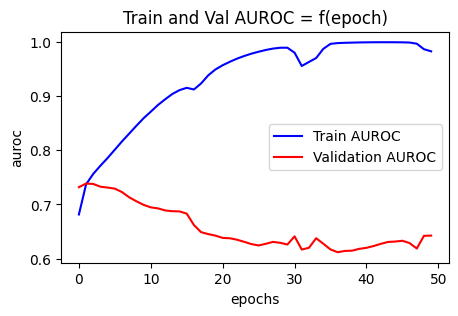

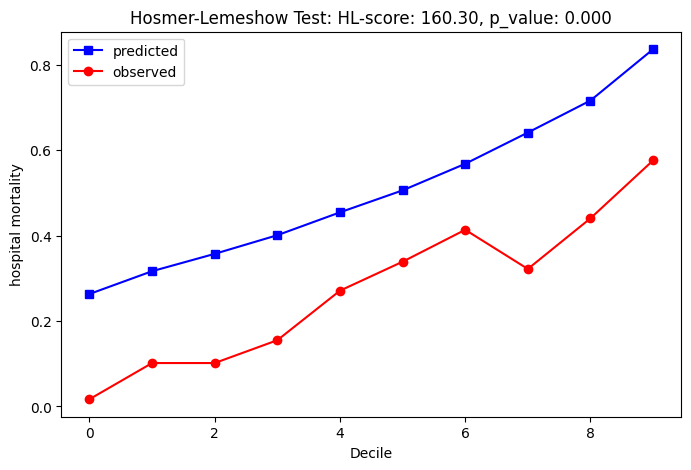

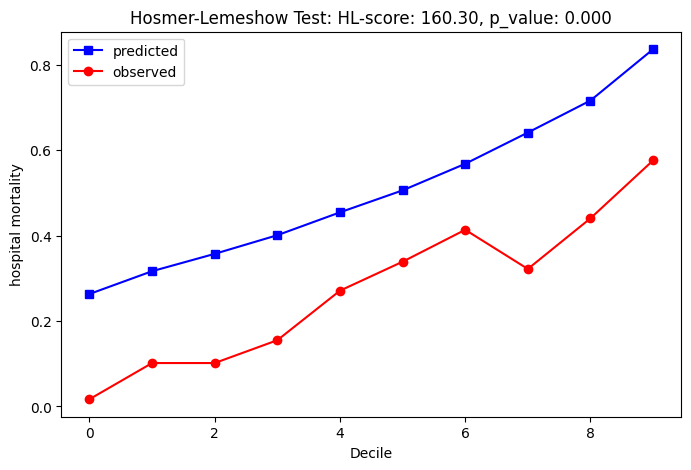


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [01:49<00:27, 13.59s/it]

test AUROC: 0.734
test Precision: 0.426
test Recall: 0.720
test Specificity: 0.537
test Accuracy: 0.658
test F1 Score: 0.536
test HL Score: 160.305
proportion deceased: 0.2605738575982997
Epoch 1/50, Train loss: 82.035, Train AUROC: 0.670
Validation Loss: 9.789, Validation AUROC: 0.745
Epoch 2/50, Train loss: 76.850, Train AUROC: 0.732
Validation Loss: 9.641, Validation AUROC: 0.755
Epoch 3/50, Train loss: 75.075, Train AUROC: 0.749
Validation Loss: 9.665, Validation AUROC: 0.752
Epoch 4/50, Train loss: 73.678, Train AUROC: 0.762
Validation Loss: 9.744, Validation AUROC: 0.747
Epoch 5/50, Train loss: 72.270, Train AUROC: 0.774
Validation Loss: 9.877, Validation AUROC: 0.739
Epoch 6/50, Train loss: 70.922, Train AUROC: 0.785
Validation Loss: 9.988, Validation AUROC: 0.732
Epoch 7/50, Train loss: 69.542, Train AUROC: 0.796
Validation Loss: 10.138, Validation AUROC: 0.725
Epoch 8/50, Train loss: 68.098, Train AUROC: 0.807
Validation Loss: 10.265, Validation AUROC: 0.718
Epoch 9/50, Train 

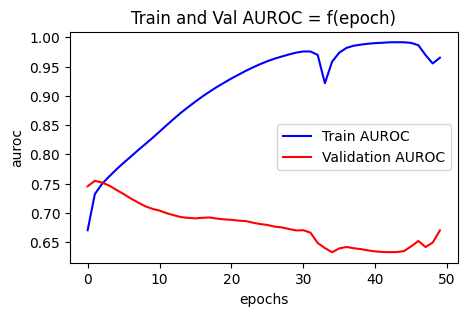

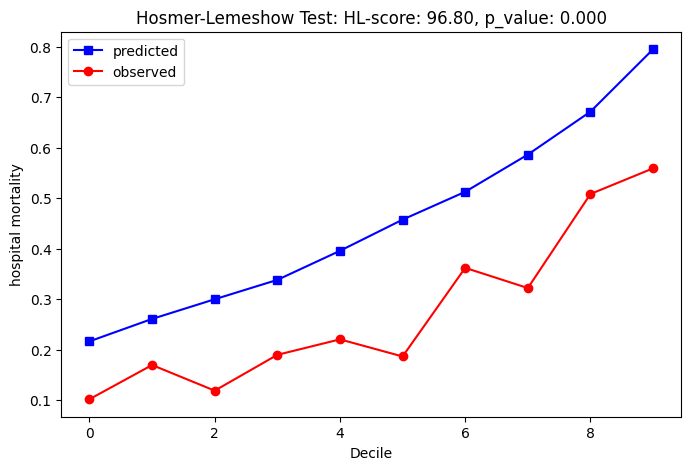

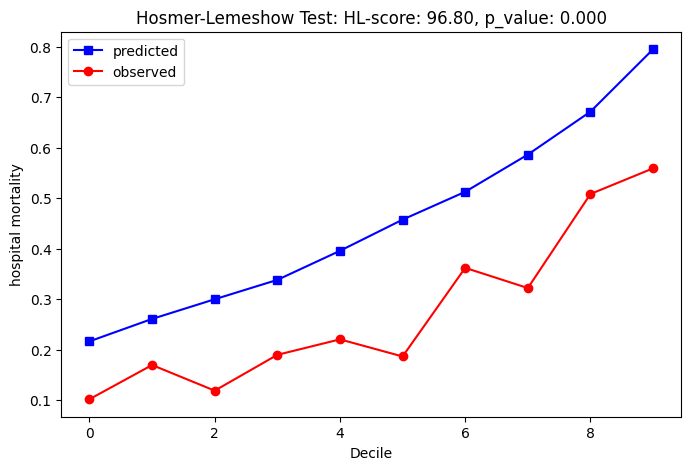


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [02:02<00:13, 13.59s/it]

test AUROC: 0.704
test Precision: 0.452
test Recall: 0.615
test Specificity: 0.628
test Accuracy: 0.690
test F1 Score: 0.521
test HL Score: 96.798
proportion deceased: 0.2627551020408163
Epoch 1/50, Train loss: 81.714, Train AUROC: 0.672
Validation Loss: 10.046, Validation AUROC: 0.753
Epoch 2/50, Train loss: 77.562, Train AUROC: 0.724
Validation Loss: 9.785, Validation AUROC: 0.762
Epoch 3/50, Train loss: 76.102, Train AUROC: 0.741
Validation Loss: 9.702, Validation AUROC: 0.761
Epoch 4/50, Train loss: 74.754, Train AUROC: 0.754
Validation Loss: 9.609, Validation AUROC: 0.763
Epoch 5/50, Train loss: 73.347, Train AUROC: 0.766
Validation Loss: 9.538, Validation AUROC: 0.765
Epoch 6/50, Train loss: 71.788, Train AUROC: 0.779
Validation Loss: 9.509, Validation AUROC: 0.764
Epoch 7/50, Train loss: 70.123, Train AUROC: 0.792
Validation Loss: 9.544, Validation AUROC: 0.761
Epoch 8/50, Train loss: 68.214, Train AUROC: 0.806
Validation Loss: 9.623, Validation AUROC: 0.757
Epoch 9/50, Train lo

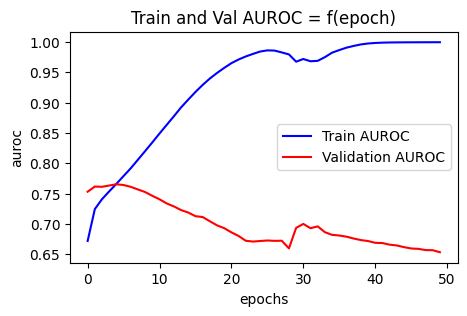

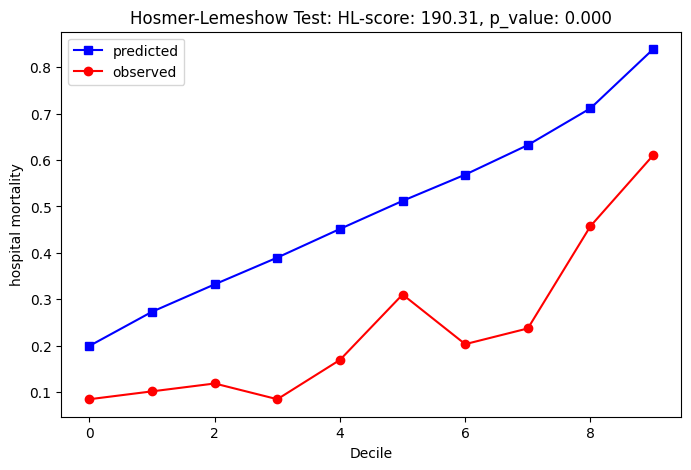

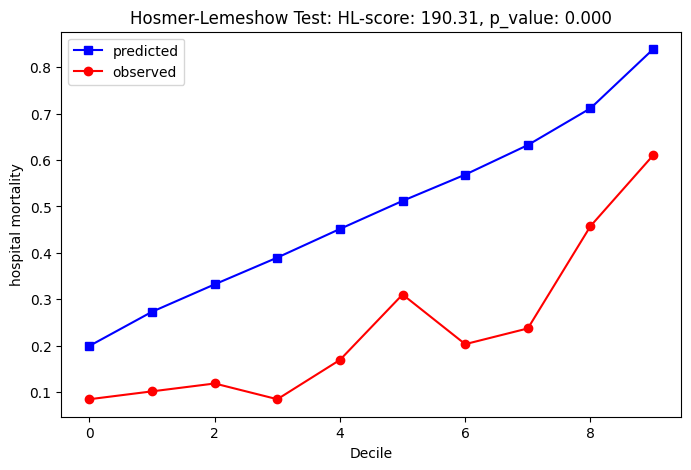


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:16<00:00, 136.29s/it]

test AUROC: 0.732
test Precision: 0.369
test Recall: 0.736
test Specificity: 0.526
test Accuracy: 0.638
test F1 Score: 0.492
test HL Score: 190.311
Mean AUROC: 0.729
Mean Precision: 0.403
Mean Recall: 0.722
Mean Specificity: 0.535
Mean Accuracy: 0.649
Mean F1 Score: 0.515
SD Auroc: 0.026
Total Mean AUROC: 0.729
Total Mean Precision: 0.403
Total Mean Recall: 0.722
Total Mean Specificity: 0.535
Total Mean Accuracy: 0.649
Total Mean F1 Score: 0.515


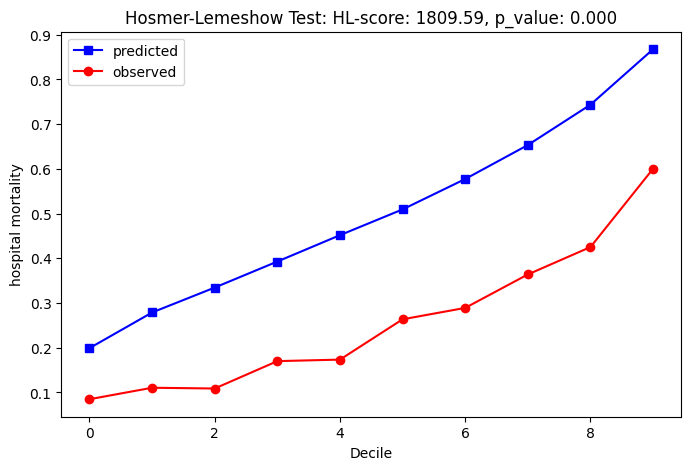

In [85]:
best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_all = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   

mean_fpr = np.linspace(0, 1, 100)
tprs = []
predictions_list = []
labels_list = []


save_path = "saved_models/test.pth"
load_path = None
# load_path = "saved_models/CNN_1D_3.pth"

K = 10
num_train = 1

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict, predictions, true_labels  =  train_model(
                                                                                    data=data_MR,
                                                                                    target=target_MR,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=50, 
                                                                                    model_name="CNN_1D_1",
                                                                                    verbose=True, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    calibration_activated = False,
                                                                                    augmentation_activated = False,
                                                                                    load_model_path = load_path
                                                                                    )
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"test AUROC: {auroc:.3f}")
        print(f"test Precision: {precision:.3f}")
        print(f"test Recall: {recall:.3f}")
        print(f"test Specificity: {tnr:.3f}")
        print(f"test Accuracy: {accuracy:.3f}")
        print(f"test F1 Score: {f1:.3f}")
        print(f"test HL Score: {HL_score:.3f}")
        
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        predictions_list = predictions_list + list(predictions)
        labels_list = labels_list + list(true_labels)
    
    print(f"Mean AUROC: {np.mean(aurocs):.3f}")
    print(f"Mean Precision: {np.mean(precisions):.3f}")
    print(f"Mean Recall: {np.mean(recalls):.3f}")
    print(f"Mean Specificity: {np.mean(tnrs):.3f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.3f}")
    print(f"Mean F1 Score: {np.mean(f1s):.3f}")
    print(f"SD Auroc: {np.std(aurocs):.3f}")

    aurocs_all = aurocs_all + aurocs
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
    
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_all):.3f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.3f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.3f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.3f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.3f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.3f}")




mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

list_to_save = [aurocs_all, mean_tpr, predictions_list, labels_list]

saved_results_folder = "./saved_results/"
saved_file_name = "CNN1D_MR_finetuned_On_ECMO_3"

with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
    pickle.dump(list_to_save, file)



deciles = np.percentile(predictions_list, np.arange(0, 101, 10))
decile_labels = pd.cut(predictions_list, bins=deciles, labels=False, include_lowest=True)

HL_num_groups = np.zeros(10)
HL_pred_groups = np.zeros(10)
HL_true_groups = np.zeros(10)

for k in range(len(predictions_list)):
    group = decile_labels[k]
    HL_num_groups[group] +=1
    HL_pred_groups[group] += predictions_list[k]
    if labels_list[k] > 0.5:
        HL_true_groups[group] += 1
        
HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
HL_p_value = 1 - chi2.cdf(HL_score, df=8)

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

plt.xlabel('Decile')
plt.ylabel('hospital mortality')
plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

plt.legend()

plt.show()

In [ ]:
# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)
torch.cuda.is_available()

In [13]:
saved_results_folder = "./saved_results/"
saved_file_name = "CNN1D_MR_finetuned_On_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]
predictions = list_result[2]
labels = list_result[3]
print(np.round(predictions[:30],1))
print(labels[:30])

[0.7 0.6 0.4 0.6 0.7 0.7 0.5 0.7 0.5 0.4 0.4 0.4 0.7 0.5 0.8 0.4 0.5 0.5
 0.1 0.3 0.3 0.5 0.7 0.2 0.6 0.5 0.3 0.3 0.9 0.2]
[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [12]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3

input_size = 1
hidden_size = 8
num_layers = 1
output_size = 1

# model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)
model = CNN_1D_1(num_features)

save_path = "./saved_models/test.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


x_test_tensor = x_test_tensor.permute(0, 2, 1)

explainer = shap.DeepExplainer(model, x_test_tensor)

# Explain a sample
sample = x_test_tensor[0:1].permute(0,2,1)
shap_values = explainer.shap_values(sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, sample.numpy())




# true_labels = []
# predictions = []
# predictions_binary = []

# treshold = 0.5

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         # inputs = inputs.permute(0, 2, 1)
#         true_labels.extend(labels.numpy())

#         outputs = nn.functional.sigmoid(model(inputs))
#         predictions.extend(outputs.numpy())
#         predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
#         # print(np.round(np.array([p[0] for p in outputs.numpy()]), 1))
#         # print(np.round(np.array(labels), 1))


# mean_fpr = np.linspace(0, 1, 100)
# tprs = []
# predictions_list = []
# labels_list = []

# fpr, tpr, _ = roc_curve(true_labels, predictions)
# tprs.append(np.interp(mean_fpr, fpr, tpr))
# tprs[-1][0] = 0.0

# predictions_list = predictions_list + list(predictions)
# labels_list = labels_list + list(true_labels)

# auroc = roc_auc_score(true_labels, predictions)

# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

# list_to_save = [auroc, mean_tpr, predictions_list, labels_list]

# saved_file_name = "LSTM_Mimic_On_ECMO"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)

2024-06-20 15:06:11.750268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 15:06:12.895973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 120 but got size 12 for tensor number 1 in the list.

In [ ]:
saved_results_folder = "./saved_results/"

mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

# Plotting the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)


saved_file_name = "LGBM_Mimic_With_First_Last"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='b', 
         label=f'LGBM (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "CNN1D_Mimic"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='r', 
         label=f'CNN 1D (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "LSTM_Mimic"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='y', 
         label=f'LSTM (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "InceptionTime_Mimic"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='g', 
         label=f'InceptionTime (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "sapsii_Mimic"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

plt.plot(mean_fpr, mean_tpr, color='c', 
         label=f'SAPS II (AUROC = {aurocs:.2f})', 
         lw=2, alpha=0.8)


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Mean ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

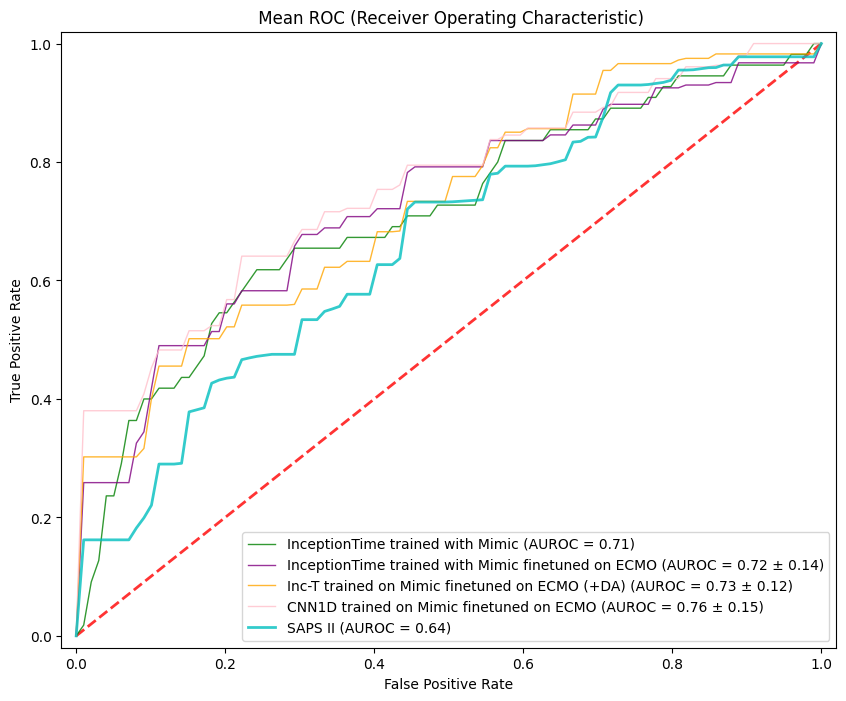

In [33]:
saved_results_folder = "./saved_results/"

mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

# Plotting the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)


# saved_file_name = "LGBM_MR_On_ECMO"
# with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
#     list_result = pickle.load(file)
# aurocs = list_result[0]
# mean_tpr = list_result[1]

# mean_auc = np.mean(aurocs)
# std_auc = np.std(aurocs)

# plt.plot(mean_fpr, mean_tpr, color='b', 
#          label=f'LGBM Trained on Mimic (AUROC = {mean_auc:.2f})', 
#          lw=1, alpha=0.8)



# saved_file_name = "CNN1D_MR_On_ECMO"
# with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
#     list_result = pickle.load(file)
# aurocs = list_result[0]
# mean_tpr = list_result[1]

# mean_auc = np.mean(aurocs)
# std_auc = np.std(aurocs)

# plt.plot(mean_fpr, mean_tpr, color='r', 
#          label=f'CNN 1D trained with Mimic (AUROC = {mean_auc:.2f})', 
#          lw=1, alpha=0.8)


# saved_file_name = "LSTM_MR_On_ECMO"
# with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
#     list_result = pickle.load(file)
# aurocs = list_result[0]
# mean_tpr = list_result[1]

# mean_auc = np.mean(aurocs)
# std_auc = np.std(aurocs)

# plt.plot(mean_fpr, mean_tpr, color='y', 
#          label=f'LSTM trained with Mimic (AUROC = {mean_auc:.2f})', 
#          lw=1, alpha=0.8)



saved_file_name = "InceptionTime_MR_On_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='g', 
         label=f'InceptionTime trained with Mimic (AUROC = {mean_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "InceptionTime_MR_Finetuned_On_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='purple', 
         label=f'InceptionTime trained with Mimic finetuned on ECMO (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "InceptionTime_MR_Finetuned_On_ECMO_With_Augm"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='orange', 
         label=f'Inc-T trained on Mimic finetuned on ECMO (+DA) (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "CNN1D_MR_finetuned_On_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='pink', 
         label=f'CNN1D trained on Mimic finetuned on ECMO (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "sapsii_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

plt.plot(mean_fpr, mean_tpr, color='c', 
         label=f'SAPS II (AUROC = {aurocs:.2f})', 
         lw=2, alpha=0.8)


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Mean ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
saved_results_folder = "./saved_results/"

mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

# Plotting the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)



saved_file_name = "CNN1D_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='r', 
         label=f'CNN 1D (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "LSTM_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='y', 
         label=f'LSTM(AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)



saved_file_name = "InceptionTime_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='g', 
         label=f'InceptionTime (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


saved_file_name = "Hydra_MR"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

mean_auc = np.mean(aurocs)
std_auc = np.std(aurocs)

plt.plot(mean_fpr, mean_tpr, color='g', 
         label=f'Hydra (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
         lw=1, alpha=0.8)


# saved_file_name = "InceptionTime_MR_Finetuned_On_ECMO"
# with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
#     list_result = pickle.load(file)
# aurocs = list_result[0]
# mean_tpr = list_result[1]

# mean_auc = np.mean(aurocs)
# std_auc = np.std(aurocs)

# plt.plot(mean_fpr, mean_tpr, color='purple', 
#          label=f'InceptionTime trained with Mimic finetuned on ECMO (AUROC = {mean_auc:.2f} ± {std_auc:.2f})', 
#          lw=1, alpha=0.8)


saved_file_name = "sapsii_ECMO"
with open(saved_results_folder + saved_file_name + ".pkl", 'rb') as file:
    list_result = pickle.load(file)
aurocs = list_result[0]
mean_tpr = list_result[1]

plt.plot(mean_fpr, mean_tpr, color='c', 
         label=f'SAPS II (AUROC = {aurocs:.2f})', 
         lw=2, alpha=0.8)


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Mean ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3

input_size = 1
hidden_size = 8
num_layers = 1
output_size = 1

# model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)
model = CNN_1D_1(num_features)

save_path = "./saved_models/test.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
        # print(np.round(np.array([p[0] for p in outputs.numpy()]), 1))
        # print(np.round(np.array(labels), 1))


auroc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary, zero_division=0)
accuracy = accuracy_score(true_labels, predictions_binary)

print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {tnr:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
from sktime.classification.deep_learning import InceptionTimeClassifier
import keras

aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

test_activated = True
validation_activated = False

data = data_MR
target = target_MR

K = 10
for j in range(K):
    num_samples = len(target)

    sub_samples_size = num_samples//K

    test_fold = j
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,K-1)
        while val_fold == test_fold:
            val_fold = random.randint(0,K-1)
    else:
        val_fold = None
    
    x_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            x_train = np.concatenate((x_train, current_data_fold))
            y_train = y_train + current_target_fold

    num_samples = len(target)
    num_timesteps = 24 * 5
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static



    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)

    
    clf = InceptionTimeClassifier(batch_size=64,
                                  metrics = [keras.metrics.AUC()], 
                                  verbose=True, 
                                  n_epochs=1,
                                  n_filters=32,
                                  depth=6,
                                  kernel_size=20, 
                                  bottleneck_size=32)  

    clf.fit(x_train, np.array(y_train))
    
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
    y_pred = clf.predict(x_test)
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)

    print(f"AUROC: {auroc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"tnr: {tnr:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate and print the mean scores
print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"tnr: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracy):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

In [ ]:
precisions_seuil = []
recalls_seuil = []
tnrs_seuil = []
accuracies_seuil = []
f1s_seuil = []

seuils = [s/100 for s in range(0,100)]

for seuil in seuils:
        
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
        
    y_pred = (y_pred_proba > seuil).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    
    precisions_seuil.append(precision)
    recalls_seuil.append(recall)
    tnrs_seuil.append(tnr)
    accuracies_seuil.append(accuracy)
    f1s_seuil.append(f1)


plt.figure(figsize=(10, 6))

plt.plot(seuils, precisions_seuil, label='precision', color='blue')
plt.plot(seuils, recalls_seuil, label='recall', color='green')
plt.plot(seuils, tnrs_seuil, label='specificity', color='yellow')
plt.plot(seuils, accuracies_seuil, label='accuracy', color='red')
plt.plot(seuils, f1s_seuil, label='f1-score', color='purple')

plt.xlabel('seuil')
plt.ylabel('metrics values')
plt.title('Metrics values = f(seuil)')

plt.legend()

plt.show()